In [76]:
%run __init__.ipynb

Successfully connected to MongoDB


In [77]:
db_trend = get_datasource('WORLD_DB_TREND')
db_trend

,ENTITY_GROUPS,ENTITY,SCENARIO,DATE,DATE_ORDER,KPI,METRIC,VALUE,DATE_SCENARIO,KPI_ORDER,UNIT,PRECISION
0,Afghanistan,Afghanistan,22/01/2020,2020-01-22,20200122,Confirmed,VALUE,0.0,Since beginning,1.0,cases,",.0f"
1,Afghanistan,Afghanistan,23/01/2020,2020-01-23,20200123,Confirmed,VALUE,0.0,Since beginning,1.0,cases,",.0f"
2,Afghanistan,Afghanistan,24/01/2020,2020-01-24,20200124,Confirmed,VALUE,0.0,Since beginning,1.0,cases,",.0f"
3,Afghanistan,Afghanistan,25/01/2020,2020-01-25,20200125,Confirmed,VALUE,0.0,Since beginning,1.0,cases,",.0f"
4,Afghanistan,Afghanistan,26/01/2020,2020-01-26,20200126,Confirmed,VALUE,0.0,Since beginning,1.0,cases,",.0f"
...,...,...,...,...,...,...,...,...,...,...,...,...
1309603,West Bank and Gaza,West Bank and Gaza,29/03/2020,2020-03-29,20200329,Recovery Rate,VARP,NaN,Last 30 days,NaN,NaN,NaN
1309604,Western Sahara,Western Sahara,29/03/2020,2020-03-29,20200329,Recovery Rate,VARP,NaN,Last 30 days,NaN,NaN,NaN
1309605,Yemen,Yemen,29/03/2020,2020-03-29,20200329,Recovery Rate,VARP,NaN,Last 30 days,NaN,NaN,NaN
1309606,Zambia,Zambia,29/03/2020,2020-03-29,20200329,Recovery Rate,VARP,NaN,Last 30 days,NaN,NaN,NaN


In [78]:
#Get top 10 countries
max_date = domain104['DATE_ORDER'].max()
filters =  ['Europe','Asia','Africa','North America','South America','Oceania','Other','To be affected']
countries = db_trend[(db_trend['ENTITY_GROUPS'].isin(filters)) & (db_trend['DATE_ORDER'] == max_date) & (db_trend['KPI'] == 'Confirmed') & (db_trend['DATE_SCENARIO'] == 'Since beginning') & (db_trend['METRIC'] == 'VALUE')].sort_values(by= 'VALUE', ascending=False)['ENTITY'].drop_duplicates().values.tolist()[:10]
print(countries)

['US', 'Spain', 'Italy', 'France', 'Germany', 'United Kingdom', 'Turkey', 'Iran', 'Russia', 'China']


In [79]:
filters = ['WORLDWIDE','Europe','Asia','Africa','North America','South America','Oceania','Other','To be affected']
domain_loga = db_trend.copy()[(db_trend['DATE_SCENARIO'] == 'Since beginning') & (db_trend['METRIC'] == 'VARV') & (db_trend['VALUE'] >= 3) & (db_trend['ENTITY_GROUPS'].isin(filters))]
domain_loga = domain_loga.drop(['DATE_SCENARIO','METRIC','DATE'],axis=1).sort_values(by=['ENTITY','DATE_ORDER'],ascending=True)
domain_loga

,ENTITY_GROUPS,ENTITY,SCENARIO,DATE_ORDER,KPI,VALUE,KPI_ORDER,UNIT,PRECISION
306275,Asia,Afghanistan,08/03/2020,20200308,Confirmed,3.000000,1.0,cases,"+,.0f"
456431,Asia,Afghanistan,08/03/2020,20200308,Active cases,3.000000,2.0,cases,"+,.0f"
306281,Asia,Afghanistan,14/03/2020,20200314,Confirmed,4.000000,1.0,cases,"+,.0f"
456437,Asia,Afghanistan,14/03/2020,20200314,Active cases,4.000000,2.0,cases,"+,.0f"
306282,Asia,Afghanistan,15/03/2020,20200315,Confirmed,5.000000,1.0,cases,"+,.0f"
...,...,...,...,...,...,...,...,...,...
305543,Africa,Zimbabwe,21/04/2020,20200421,Confirmed,3.000000,1.0,cases,"+,.0f"
455699,Africa,Zimbabwe,21/04/2020,20200421,Active cases,3.000000,2.0,cases,"+,.0f"
505752,Africa,Zimbabwe,22/04/2020,20200422,Fatality Rate,3.571429,NaN,NaN,NaN
405653,Africa,Zimbabwe,27/04/2020,20200427,Recovered,3.000000,3.0,cases,"+,.0f"


In [80]:
filters = domain_loga[['ENTITY','KPI']].drop_duplicates().values.tolist()
domain104 = pd.DataFrame()
for f in filters:
    entity = f[0]
    kpi = f[1]
    tmp_df = domain_loga[(domain_loga['ENTITY'] == entity) & (domain_loga['KPI'] == kpi)]
    tmp_df = tmp_df.sort_values(by='DATE_ORDER',ascending=True).reset_index(drop=True)
    tmp_df['INDEX'] = tmp_df.index
    tmp_df['DATE'] = 'D' + tmp_df['INDEX'].astype(str)

    def calc_ave(row,df):
        i_min = row['INDEX'] - 7
        i_max = row['INDEX']
        list_filters = []
        for i in range(i_min,i_max):
            list_filters.append(str(i))
        df = df[df['INDEX'].isin(list_filters)]
        average = df['VALUE'].mean()
        return average

    tmp_df['VALUE_LOGA'] = tmp_df.apply(lambda row: calc_ave(row,tmp_df), axis=1).fillna(0)
    domain104 = domain104.append(tmp_df)
    
domain104 = domain104[(domain104['ENTITY'].isin(countries))]

domain104.info()
domain104

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2160 entries, 0 to 42
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ENTITY_GROUPS  2160 non-null   object 
 1   ENTITY         2160 non-null   object 
 2   SCENARIO       2160 non-null   object 
 3   DATE_ORDER     2160 non-null   int64  
 4   KPI            2160 non-null   object 
 5   VALUE          2160 non-null   float64
 6   KPI_ORDER      2100 non-null   float64
 7   UNIT           2100 non-null   object 
 8   PRECISION      2100 non-null   object 
 9   INDEX          2160 non-null   int64  
 10  DATE           2160 non-null   object 
 11  VALUE_LOGA     2160 non-null   float64
dtypes: float64(3), int64(2), object(7)
memory usage: 219.4+ KB


,ENTITY_GROUPS,ENTITY,SCENARIO,DATE_ORDER,KPI,VALUE,KPI_ORDER,UNIT,PRECISION,INDEX,DATE,VALUE_LOGA
0,Asia,China,22/01/2020,20200122,Confirmed,548.0,1.0,cases,"+,.0f",0,D0,0.000000
1,Asia,China,23/01/2020,20200123,Confirmed,95.0,1.0,cases,"+,.0f",1,D1,548.000000
2,Asia,China,24/01/2020,20200124,Confirmed,277.0,1.0,cases,"+,.0f",2,D2,321.500000
3,Asia,China,25/01/2020,20200125,Confirmed,486.0,1.0,cases,"+,.0f",3,D3,306.666667
4,Asia,China,26/01/2020,20200126,Confirmed,669.0,1.0,cases,"+,.0f",4,D4,351.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
38,Europe,United Kingdom,23/04/2020,20200423,Deaths,640.0,4.0,cases,"+,.0f",38,D38,751.000000
39,Europe,United Kingdom,24/04/2020,20200424,Deaths,776.0,4.0,cases,"+,.0f",39,D39,718.857143
40,Europe,United Kingdom,25/04/2020,20200425,Deaths,814.0,4.0,cases,"+,.0f",40,D40,708.571429
41,Europe,United Kingdom,26/04/2020,20200426,Deaths,413.0,4.0,cases,"+,.0f",41,D41,697.571429


In [81]:
domain104.to_csv(output_folder + '104.csv',sep=";")
if use_mongo:
    bob.mongo.save_df(domain104,'104',db_app,True)

Dataframe 104 successfully save in database app-wsr-dev in MongoDB. Time: --- 0.10832858085632324 secnds ---


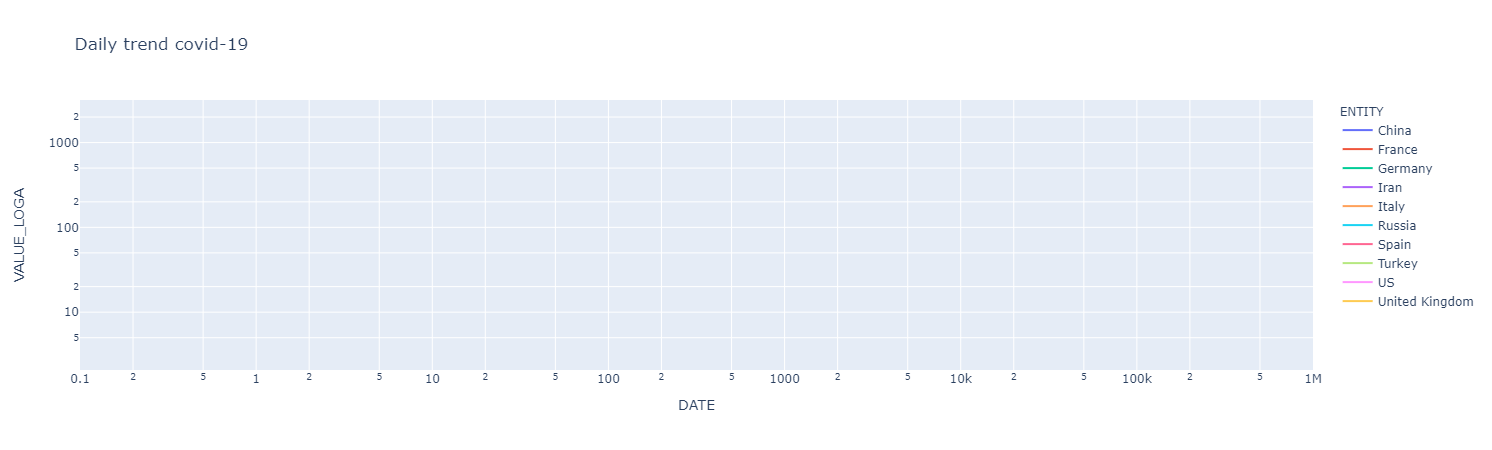

In [100]:
import plotly.graph_objects as go

fig = go.Figure()

dfD = domain104[domain104['KPI'] == 'Deaths']
fig = px.line(dfD, x="DATE", y="VALUE_LOGA", color='ENTITY', title='Daily trend covid-19')

# fig.add_trace(go.Scatter(
#     y=[1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
# ))

# fig.update_layout(xaxis_type="log", yaxis_type="log")
# fig.update_xaxes(type="log")
# fig.update_yaxes(type="log")
fig.show()